# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage
import warnings

In [2]:
warnings.filterwarnings("ignore")

# Фукция для отображения картинки

In [3]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image)
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(6, 4))
    plt.axis("off")
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

In [4]:
img = cv2.imread("image.jpg") # загружаем картинку
img = cv2.resize(img, (128, 128))

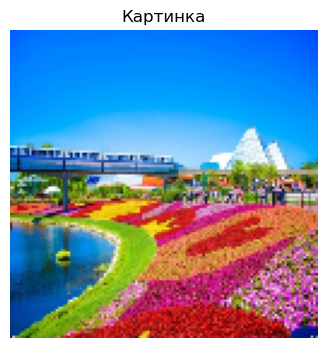

In [5]:
draw_picture(img, "Картинка") # выводим на экран

# Сжатие цветов через KMeans

In [47]:
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim


def color_quantization_with_kmeans(image, n_clusters=2):
    reshaped_image = np.reshape(
    image, 
      ((image.shape[0] * image.shape[1]), 3)) # перевод в матрицу, где строка - пиксель, значения в строке - RGB
    
    model = KMeans(n_clusters=n_clusters)
    target = model.fit_predict(reshaped_image)
    print(target)
    color_space = model.cluster_centers_
    
    output_image = np.reshape(color_space.astype(
    "uint8")[target], (image.shape[0], image.shape[1], 3))
    
    input_image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    output_image_gray = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
    
    score = ssim(input_image_gray, output_image_gray)
    
    draw_picture(output_image, f"Картинка с\nn_clusters = {n_clusters}\n score = {score}")

[1 1 1 ... 1 1 0]


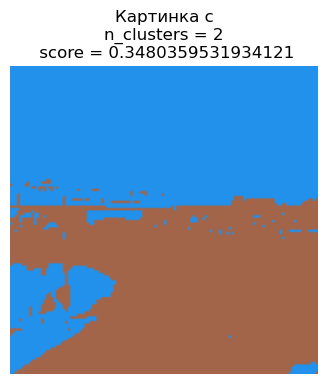

[0 0 0 ... 3 2 1]


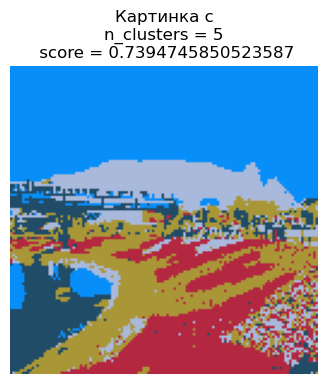

In [48]:
color_quantization_with_kmeans(img, n_clusters=2)

color_quantization_with_kmeans(img, n_clusters=5)

[0 0 0 ... 5 6 7]


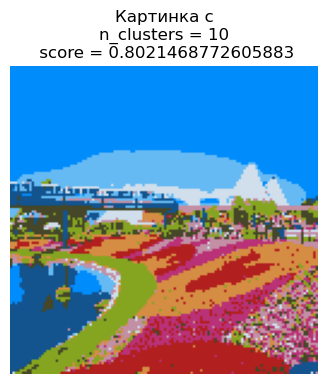

[ 1  1  1 ...  7 17  0]


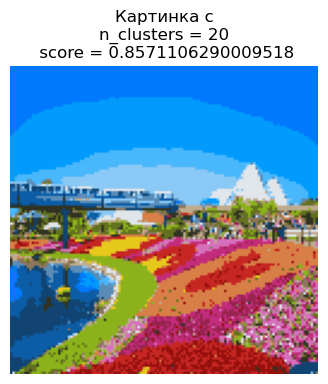

In [14]:
color_quantization_with_kmeans(img, n_clusters=10)

color_quantization_with_kmeans(img, n_clusters=20)

# Сжатие цветов через DBSCAN

In [54]:
from sklearn.cluster import DBSCAN


def color_quantization_with_dbscan(image, eps=0.5):
    reshaped_image = np.reshape(
    image, 
      ((image.shape[0] * image.shape[1]), 3)) # перевод в матрицу, где строка - пиксель, значения в строке - RGB
    
    model = DBSCAN(eps=eps, min_samples=2)
    target = model.fit_predict(reshaped_image)
    unique_labels = np.unique(model.labels_)

    color_space = []

    for label in unique_labels:
        points = reshaped_image[model.labels_ == label]
        centroid = np.mean(points, axis=0)
        color_space.append(centroid)

    color_space = np.asarray(color_space)

    output_image = np.reshape(color_space.astype(
    "uint8")[target], (image.shape[0], image.shape[1], 3))
    
    input_image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    output_image_gray = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
    
    score = ssim(input_image_gray, output_image_gray)
    
    draw_picture(output_image, f"Картинка с\neps = {eps}\nscore = {score}")
    

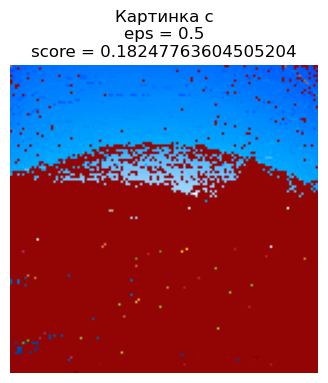

In [55]:
color_quantization_with_dbscan(img)

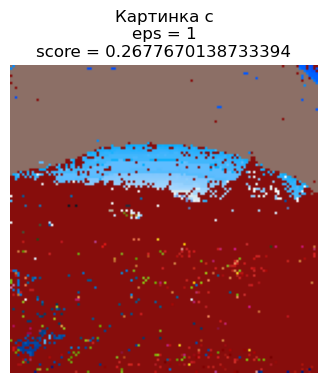

In [56]:
color_quantization_with_dbscan(img, eps=1) # Попробовал увеличить eps

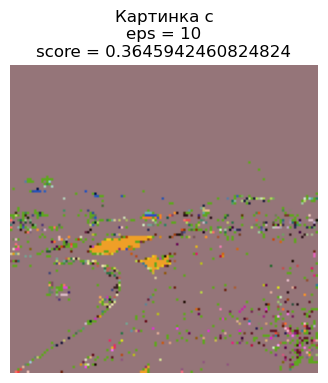

In [57]:
color_quantization_with_dbscan(img, eps=10) # Попробовал взять очень большой eps

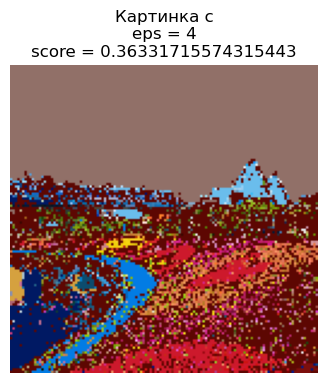

In [58]:
color_quantization_with_dbscan(img, eps=4) # Лучший eps, который мне удалось подобрать самостоятельно

# Сжатие цветов через AgglomerativeClustering

In [9]:
from sklearn.cluster import AgglomerativeClustering


def color_quantization_with_agg_cluster(image, n_clusters=2):
    reshaped_image = np.reshape(
    image, 
      ((image.shape[0] * image.shape[1]), 3)) # перевод в матрицу, где строка - пиксель, значения в строке - RGB
    
    model = AgglomerativeClustering(n_clusters=n_clusters)
    target = model.fit_predict(reshaped_image)
    unique_labels = np.unique(model.labels_)

    color_space = []

    for label in unique_labels:
        points = reshaped_image[model.labels_ == label]
        centroid = np.mean(points, axis=0)
        color_space.append(centroid)

    color_space = np.asarray(color_space)

    output_image = np.reshape(color_space.astype(
    "uint8")[target], (image.shape[0], image.shape[1], 3))
    
    input_image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    output_image_gray = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
    
    score = ssim(input_image_gray, output_image_gray)
    
    draw_picture(output_image, f"Картинка с\nn_clusters = {n_clusters}\nscore = {score}")
    

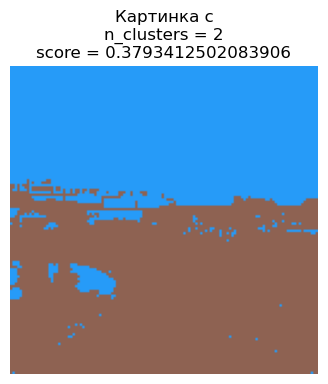

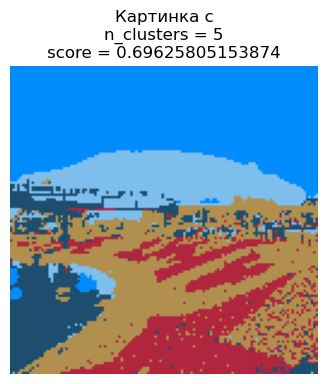

In [10]:
color_quantization_with_agg_cluster(img, n_clusters=2)

color_quantization_with_agg_cluster(img, n_clusters=5)

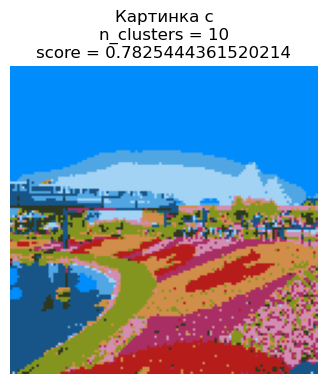

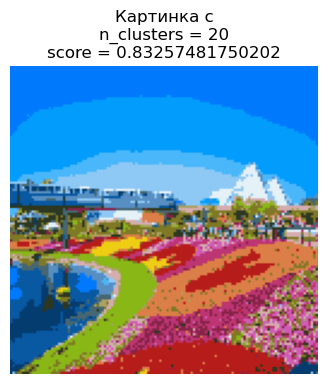

In [11]:
color_quantization_with_agg_cluster(img, n_clusters=10)

color_quantization_with_agg_cluster(img, n_clusters=20)

# Результаты

In [60]:
models = ["KMeans", "DBSCAN", "AgglomerativeClustering"]

scores = [0.857, 0.363, 0.832]

results_df = pd.DataFrame({"Модель": models, "Лучшая оценка (SSIM)": scores})

results_df

,Модель,Лучшая оценка (SSIM)
0,KMeans,0.857
1,DBSCAN,0.363
2,AgglomerativeClustering,0.832


# Вывод

Мы можем заметить, что DBSCAN явно хуже справилась с задачей (Я предполагаю, что это связано с форматом представления цвета => eps не могут нормально захватить область с похожими оттенками цвета). KMeans и AgglomerativeClustering явно лучше справились с этой задачей. Но у AgglomerativeClustering есть и огромный минус - модель слишком ресурсозатратная (из-за неё пришлось сжимать картинку до 128x128). 

В задаче подобного плана я с полной уверенностью выбрал бы KMeans.